# Combine analysis results

In [12]:
import pandas as pd
import respiration.utils as utils

analysis_dir = utils.dir_path('outputs', 'analysis')
fine_tuned_path = utils.join_paths(analysis_dir, 'fine_tuned_analysis.csv')
pretrained_path = utils.join_paths(analysis_dir, 'pretrained_analysis.csv')
unsupervised_path = utils.join_paths(analysis_dir, 'unsupervised_analysis.csv')
raft_path = utils.join_paths(analysis_dir, 'raft_analysis.csv')

fine_tuned = pd.read_csv(fine_tuned_path)
pretrained = pd.read_csv(pretrained_path)
unsupervised = pd.read_csv(unsupervised_path)
raft = pd.read_csv(raft_path)

## Harmonize analysis results

In [13]:
# Only keep roi==chest, because it is the most accurate
unsupervised = unsupervised[unsupervised['roi'] == 'chest']

# Remove roi column
unsupervised = unsupervised.drop(columns=['roi'])

# Rename method to model
unsupervised = unsupervised.rename(columns={'method': 'model'})

In [14]:
# Rename model_id to model
fine_tuned = fine_tuned.rename(columns={'model_id': 'model'})

In [15]:
# Only keep roi==chest, because it is the most accurate
raft = raft[raft['roi'] == 'chest']

# Remove roi column
raft = raft.drop(columns=['roi'])

In [16]:
# Merge all dataframes
analysis = pd.concat([fine_tuned, pretrained, unsupervised, raft])

metrics = [
    'pk_error',
    'cp_error',
    'nfcp_error',
    'psd_error',
    'distance_mse',
    'distance_pearson',
    'distance_dtw',
]

# Only keep relevant metrics
analysis = analysis[analysis['metric'].isin(metrics)]

## Compare all models

In [17]:
analysis

,model,subject,setting,metric,result
2,20240504_001813,Proband21,101_natural_lighting,pk_error,0.900000
5,20240504_001813,Proband21,101_natural_lighting,cp_error,1.800000
8,20240504_001813,Proband21,101_natural_lighting,nfcp_error,3.600000
12,20240504_001813,Proband21,101_natural_lighting,distance_mse,0.014414
13,20240504_001813,Proband21,101_natural_lighting,distance_pearson,0.216617
...,...,...,...,...,...
51,raft_small,Proband26,101_natural_lighting,nfcp_error,3.000000
52,raft_small,Proband26,101_natural_lighting,psd_error,8.000000
53,raft_small,Proband26,101_natural_lighting,distance_mse,0.052108
54,raft_small,Proband26,101_natural_lighting,distance_pearson,0.507811


In [18]:
model_scores = []

for model in analysis['model'].unique():
    model_data = analysis[analysis['model'] == model]

    for metric in metrics:
        metric_data = model_data[model_data['metric'] == metric]
        if len(metric_data) != 0:
            model_scores.append({
                'model': model,
                'metric': metric,
                'mean': metric_data['result'].mean(),
                'std': metric_data['result'].std(),
            })

model_scores = pd.DataFrame(model_scores)
model_scores

,model,metric,mean,std
0,20240504_001813,pk_error,2.850000,2.508187
1,20240504_001813,cp_error,5.100000,3.387477
2,20240504_001813,nfcp_error,7.500000,3.528031
3,20240504_001813,distance_mse,0.063064,0.035559
4,20240504_001813,distance_pearson,0.046659,0.443770
...,...,...,...,...
56,raft_small,nfcp_error,4.083333,1.127312
57,raft_small,psd_error,12.000000,3.464102
58,raft_small,distance_mse,0.057519,0.004812
59,raft_small,distance_pearson,-0.000680,0.466028


In [19]:
# Store the model scores
output_path = utils.dir_path('outputs', 'analysis', mkdir=True)
model_scores.to_csv(utils.join_paths(output_path, 'model_scores.csv'), index=False)

In [20]:
# Determine the best model for each metric
best_models = []

for metric in metrics:
    metric_data = model_scores[model_scores['metric'] == metric]

    if metric == "distance_pearson":
        value = metric_data['mean'].max()
    else:
        value = metric_data['mean'].min()

    best_model = metric_data[metric_data['mean'] == value]
    best_models.append(best_model)

best_models = pd.concat(best_models)
best_models

,model,metric,mean,std
54,raft_small,pk_error,0.833333,0.577350
55,raft_small,cp_error,2.583333,1.464866
38,mtts_can,nfcp_error,3.770088,2.259586
57,raft_small,psd_error,12.000000,3.464102
58,raft_small,distance_mse,0.057519,0.004812
22,20240504_163423,distance_pearson,0.118232,0.200983
41,mtts_can,distance_dtw,7.898853,2.716530


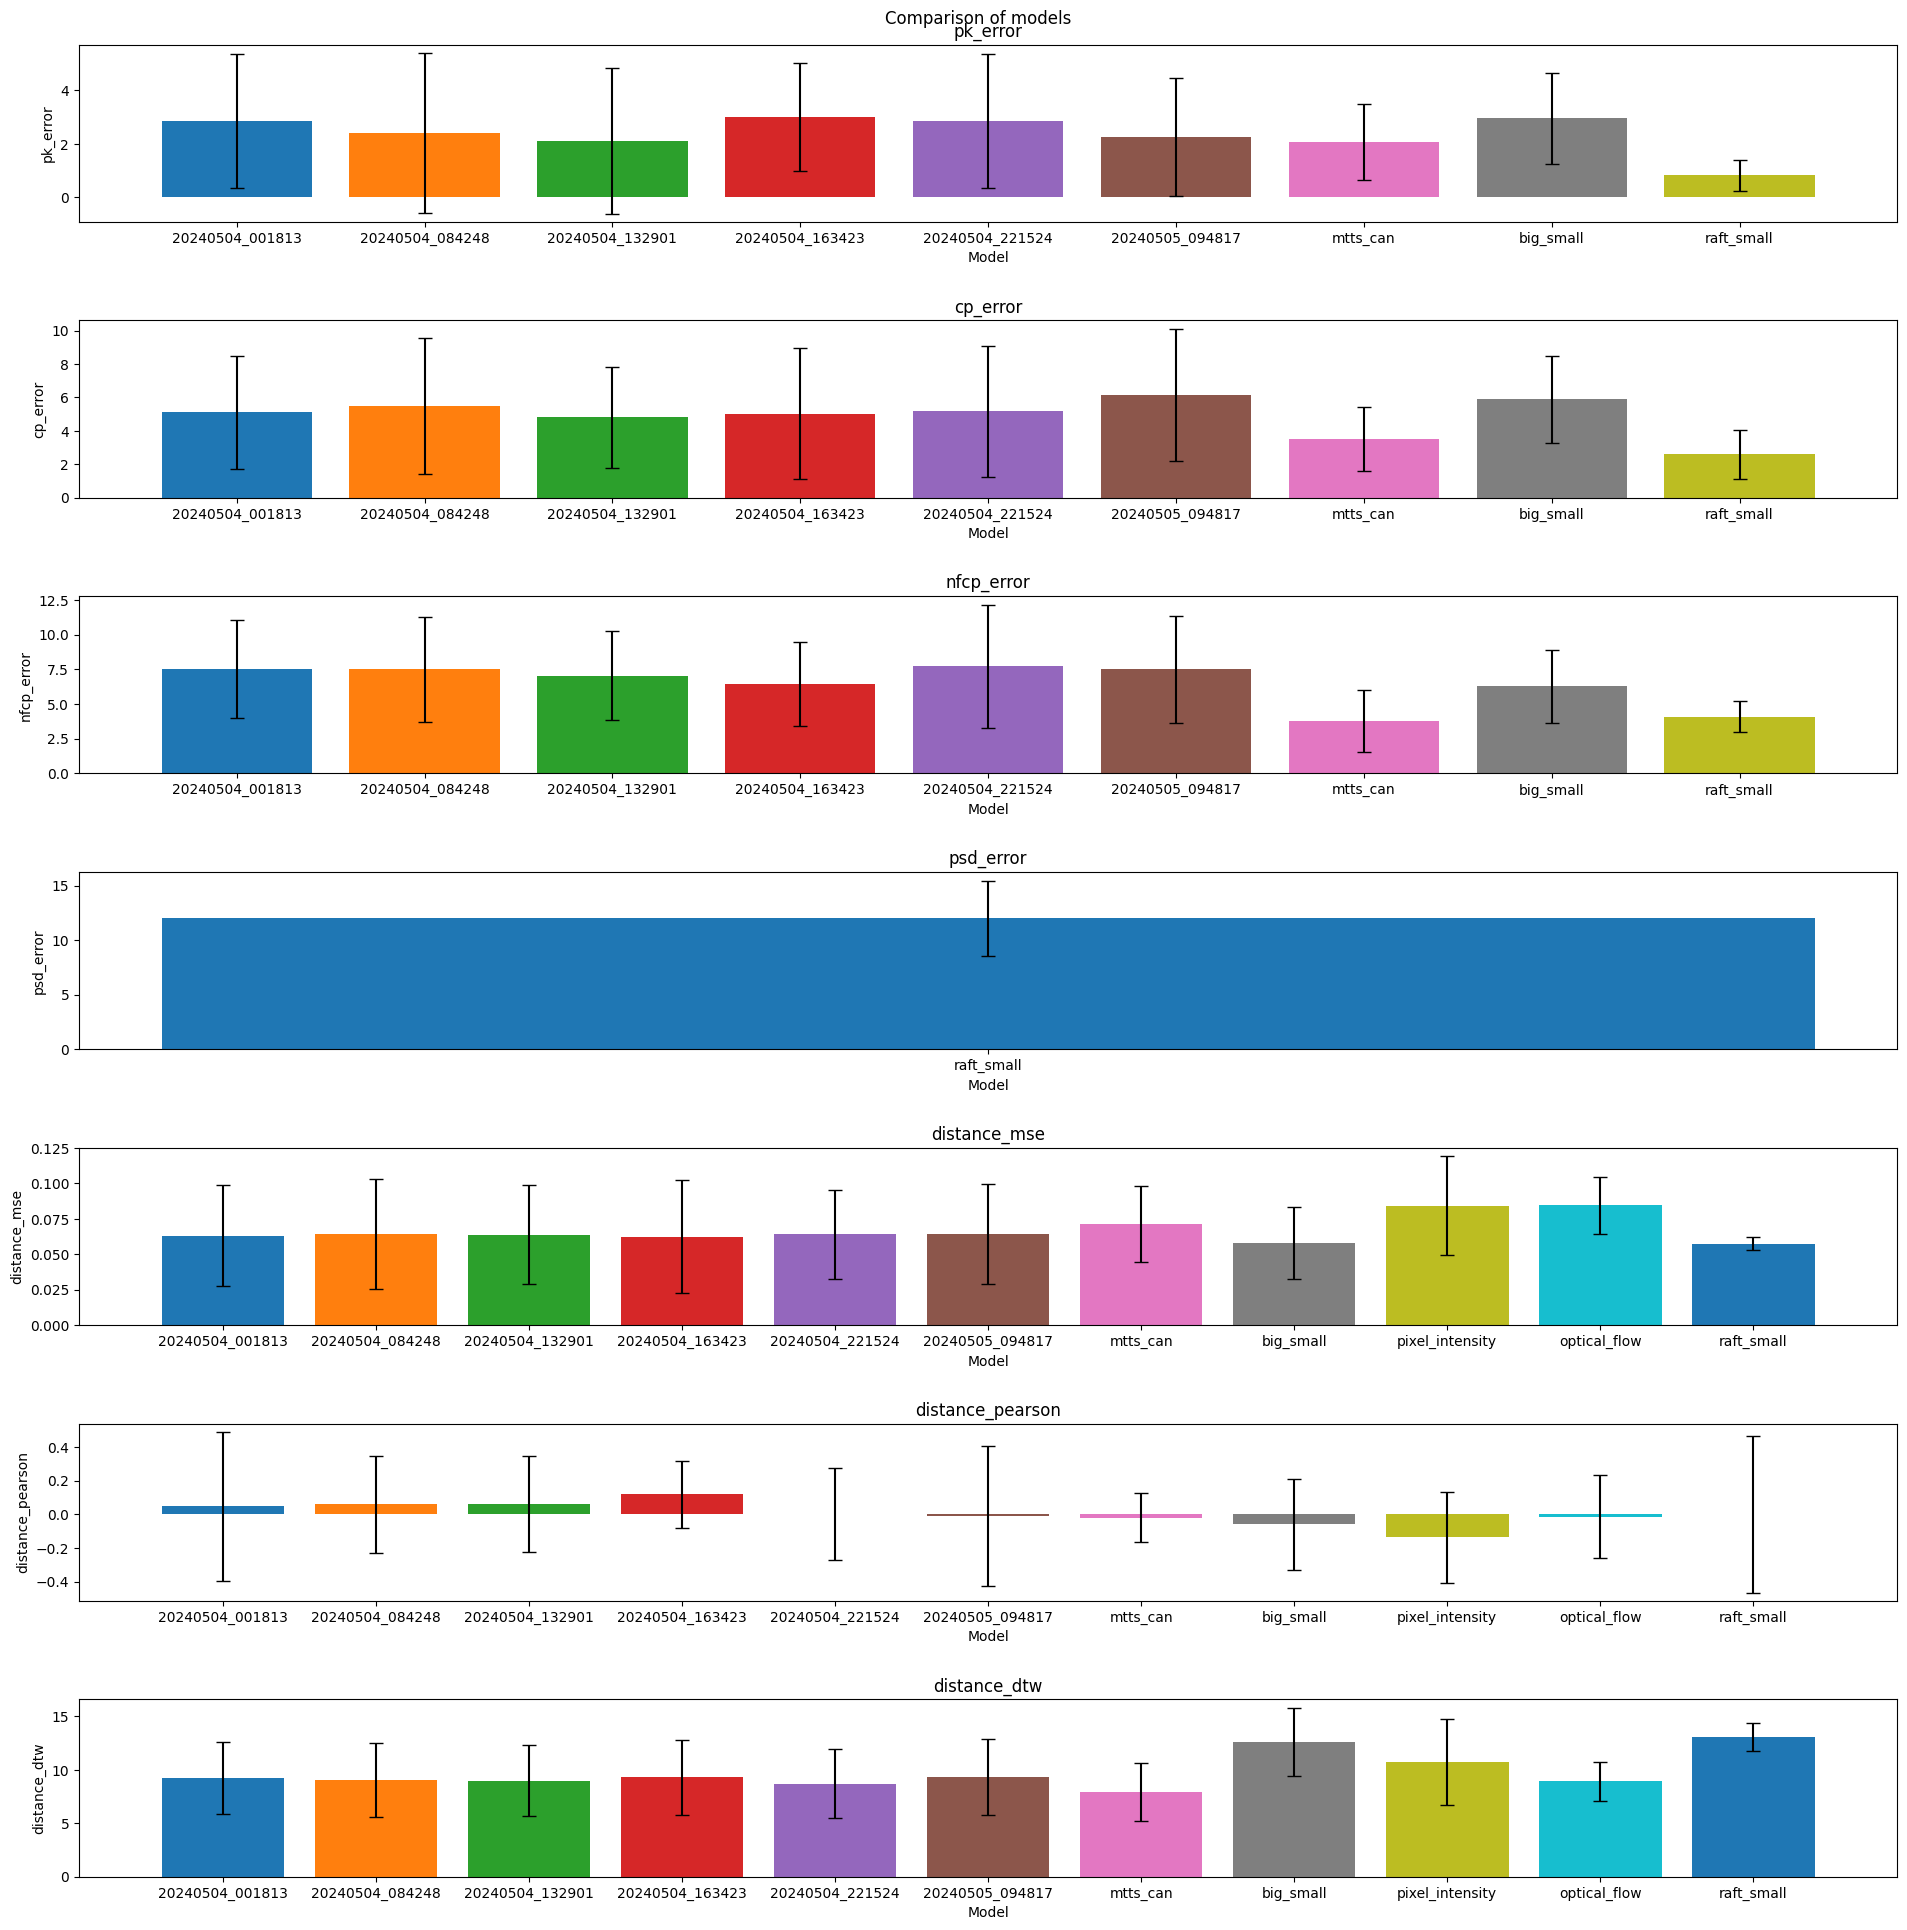

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20))

# Add some space between the plots
fig.tight_layout(pad=10.0)

# Add some space between the plots
fig.tight_layout(pad=5.0)

fig.suptitle('Comparison of models')

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    scores = model_scores[model_scores['metric'] == metric]

    for _, data in scores.iterrows():
        ax.bar(data['model'], data['mean'], yerr=data['std'], capsize=5)

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')

    # Rotate the x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

# Store the plot as svg
figure_dir = utils.dir_path('outputs', 'figures', mkdir=True)
utils.savefig(fig, figure_dir, 'model_comparison')